# Classification des images enneigées via l'analyse des histogrammes
1. Récupération des données de référence

2. Création des histogrammes de référence
    - Histogramme moyen
    - Histogramme pixels stack
    - Histogramme DBA
    - Enregistrement des histogrammes de référence

3. Comparaison des similitudes
    - Distance euclidienne
    - Corrélation, ...
    - Entropie croisée
    
4. Evaluation des performances

*Note : L'étude menée ici est réalisée sur des imagettes mais peut être transposée sur des clusters*


In [1]:
import matplotlib.pyplot as plt
import os
import cv2 as cv
import glob
import numpy as np
import random
import sys

from ast import AugStore
from sklearn.model_selection import train_test_split
from numpy.random import multivariate_normal
from keras.models import load_model
from matplotlib import colors
from scipy.special import rel_entr, kl_div
from skimage.io import imread, imshow
from tqdm.notebook import tqdm
from PIL import Image, ImageOps
from scipy.spatial import distance

dir  = os.getcwd()
dir,__ = os.path.split(dir)
sys.path.append(dir + '/codes')
from DBA import *

2022-07-26 13:18:06.534061: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/listic/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-26 13:18:06.534080: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 1. Récupération des données de référence

In [2]:
dir  = os.getcwd()
dir,__ = os.path.split(dir)
print(dir)

/home/listic/Bureau/Segmentation_neige


In [3]:
""" ouverture des images """
def getTrainningRef(patchSize):
    """ patchSize = 5, 9 ou 25 """  
    trainImagettesNeige = [] 
    trainImagettesSansNeige = [] 
    os.chdir(dir + f'/data/Supervise/{patchSize}/')

    # sélection des imagettes positives
    imgs_path = os.listdir('Avec_neige')
    for i in imgs_path:
        trainImagettesNeige.append(cv.imread(f'Avec_neige/{i}'))
    random.Random(1337).shuffle(trainImagettesNeige)

    # sélection des imagettes négatives
    imgs_path = os.listdir('Sans_neige')
    for i in imgs_path:
        trainImagettesSansNeige.append(cv.imread(f"Sans_neige/{i}"))
    random.Random(1337).shuffle(trainImagettesNeige)

    return trainImagettesSansNeige, trainImagettesNeige

patchSize = 9
trainImagettesSansNeige, trainImagettesNeige = getTrainningRef(patchSize)

visualisation d'un échantillon des données d'entrainement

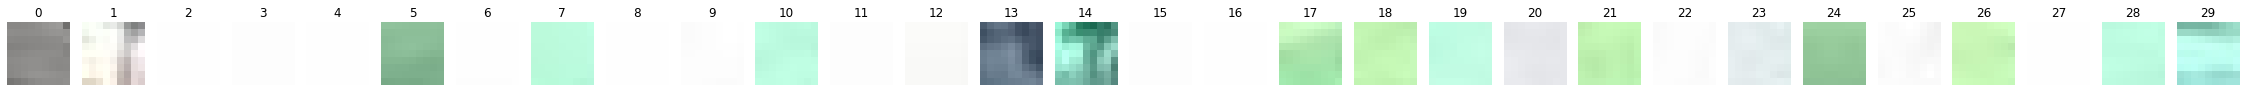

In [4]:
fig, axs = plt.subplots(1, 30, figsize = (40, 3))
for i, imA in zip(range(30), trainImagettesNeige[::10]):
    axs[i].imshow(cv.cvtColor(imA, cv.COLOR_BGR2RGB))
    axs[i].set_title(i)
    axs[i].set_axis_off()
plt.show()

**Split des données**

In [5]:
# split : 70% training, 30% validation
y = np.zeros(len(trainImagettesNeige))
neige_train, neige_test, _, _ = train_test_split(trainImagettesNeige, y, test_size=0.3, random_state=0)
y = np.zeros(len(trainImagettesSansNeige))
sans_neige_train, sans_neige_test, _, _ = train_test_split(trainImagettesSansNeige, y, test_size=0.3, random_state=0)

## 2. Création des histogrammes de référence
Extraction des caractéristiques de réference depuis le dataset

In [6]:
def normalize(values):
    """retourne la liste en pourcentage"""
    res, somme = [], sum(values)
    for value in values:
        res.append(value/(somme))
    return res

#### Histogramme moyen

In [17]:
# 20 minutes min
histogrammesB, histogrammesG, histogrammesR = [], [], []

for count, img in enumerate(tqdm(neige_train)):
    histogrammesB.append(normalize(cv.calcHist([img],[0],None,[256],[0,256])))
    histogrammesG.append(normalize(cv.calcHist([img],[1],None,[256],[0,256])))
    histogrammesR.append(normalize(cv.calcHist([img],[2],None,[256],[0,256])))

    histMoyB, histMoyG, histMoyR = [], [], []
    for k in range(256):
        tempB, tempG, tempR = [], [], []
        for j in range(len(histogrammesB)):
            tempB.append(histogrammesB[j][k])
            tempG.append(histogrammesG[j][k])
            tempR.append(histogrammesR[j][k])
        histMoyB.append(np.mean(tempB))
        histMoyG.append(np.mean(tempG))
        histMoyR.append(np.mean(tempR))

hists_moy = [histMoyB, histMoyG, histMoyR]

  0%|          | 0/2375 [00:00<?, ?it/s]

Plot de l'histogramme caractéristique de la neige

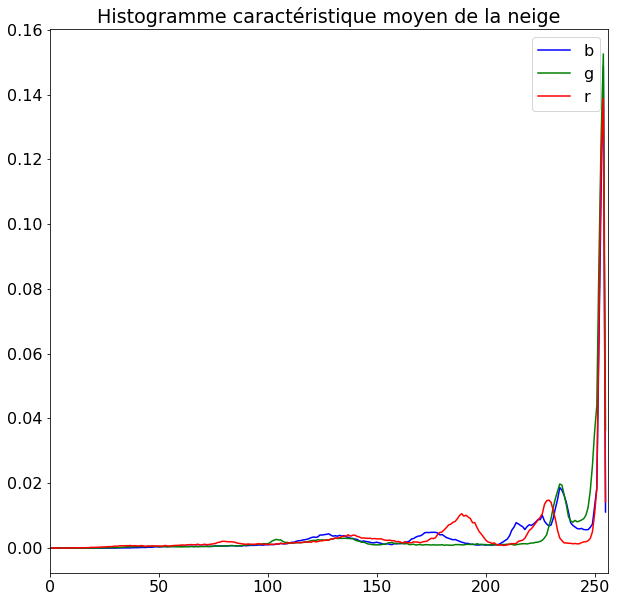

In [18]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,10))
plt.title("Histogramme caractéristique moyen de la neige")
color = ('b','g','r')
for i,col in enumerate(color):
    plt.plot(hists_moy[i],color = col)
    plt.xlim([0,256])
    plt.legend(color)
plt.show()

#### Histogramme pixels stack
Récupération de tout les pixels r, g et b associés aux imagettes

In [13]:
stackR, stackG, stackB = [], [], []
for img in tqdm(neige_train):
    stackR.extend(img.flatten()[:patchSize**2])
    stackG.extend(img.flatten()[patchSize**2:2*patchSize**2])
    stackB.extend(img.flatten()[2*patchSize**2:])
    
hists_stack = [normalize(cv.calcHist(np.array(stackR).reshape(9, 9*len(neige_train)), [0], None,[256],[0,256])), 
            normalize(cv.calcHist(np.array(stackG).reshape(9, 9*len(neige_train)), [0], None,[256],[0,256])), 
            normalize(cv.calcHist(np.array(stackB).reshape(9, 9*len(neige_train)), [0], None,[256],[0,256]))]

  0%|          | 0/2375 [00:00<?, ?it/s]

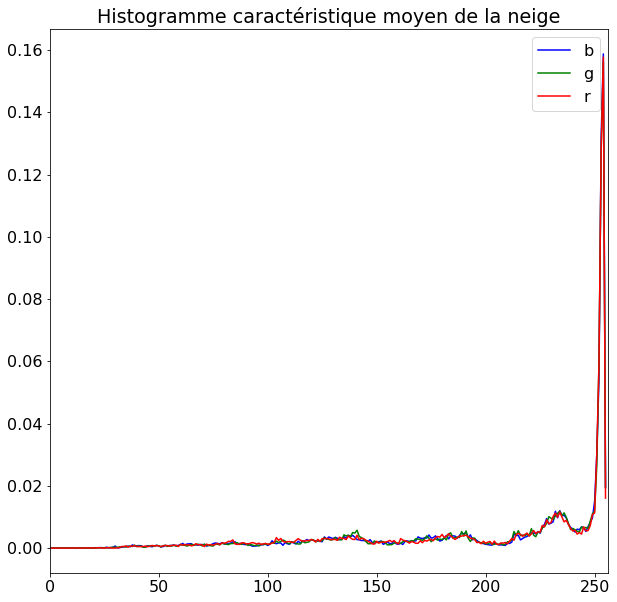

In [21]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,10))
plt.title("Histogramme caractéristique moyen de la neige")
color = ('b','g','r')
for i,col in enumerate(color):
    plt.plot(hists_stack[i],color = col)
    plt.xlim([0,256])
    plt.legend(color)
plt.show()

#### Histogramme DBA
Creation de l'hist de ref depuis les imagettes

In [56]:
# 1h40 par canal soit environ 5h  au total
hb, hg, hr = [], [], []
for img in neige_train:
    hb.append(normalize(cv.calcHist(img,[0],None,[256],[0,256])))
    hg.append(normalize(cv.calcHist(img,[1],None,[256],[0,256])))
    hr.append(normalize(cv.calcHist(img,[2],None,[256],[0,256])))

hhB, hhG, hhR = [], [], []
for hist in hb:
    hhB.append([i[0] for i in hist])
    hhG.append([i[0] for i in hist])
    hhR.append([i[0] for i in hist])

hhImagettes = [hhB, hhG, hhR]
# series=[h[0], h[1], h[2]]
seriesB=np.array(hhImagettes[0])
seriesG=np.array(hhImagettes[1])
seriesR=np.array(hhImagettes[2])

#calculating average series with DBA
histRefImagettesB = performDBA(seriesB, n_iterations=10)
histRefImagettesG = performDBA(seriesG, n_iterations=10)
histRefImagettesR = performDBA(seriesR, n_iterations=10)

hists_DBA = [histRefImagettesR, histRefImagettesG, histRefImagettesB]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

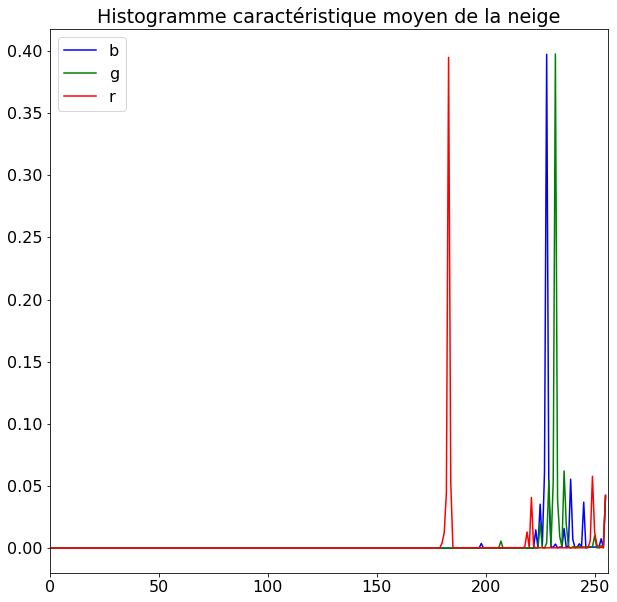

In [22]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,10))
plt.title("Histogramme caractéristique moyen de la neige")
color = ('b','g','r')
for i,col in enumerate(color):
    plt.plot(hists_DBA[i],color = col)
    plt.xlim([0,256])
    plt.legend(color)
plt.show()

#### Enregistrement des histogrammes de référence

In [7]:
import pickle

os.chdir(dir + f'/data/Supervise/')

# écriture
# with open('hist_moy_9.pkl', 'wb') as f:
#     pickle.dump(hists_moy, f)
# with open('hist_stack_9.pkl', 'wb') as f:
#     pickle.dump(hists_stack, f)
# with open('hist_DBA_9.pkl', 'wb') as f:
#     pickle.dump(hists_DBA, f)

# lecture
with open('hist_moy_9.pkl', 'rb') as f:
    hists_moy = pickle.load(f)

with open('hist_stack_9.pkl', 'rb') as f:
    hists_stack = pickle.load(f)

with open('hist_DBA_9.pkl', 'rb') as f:
    hists_DBA = pickle.load(f)

**Visualisation des trois histogrammes de référence**

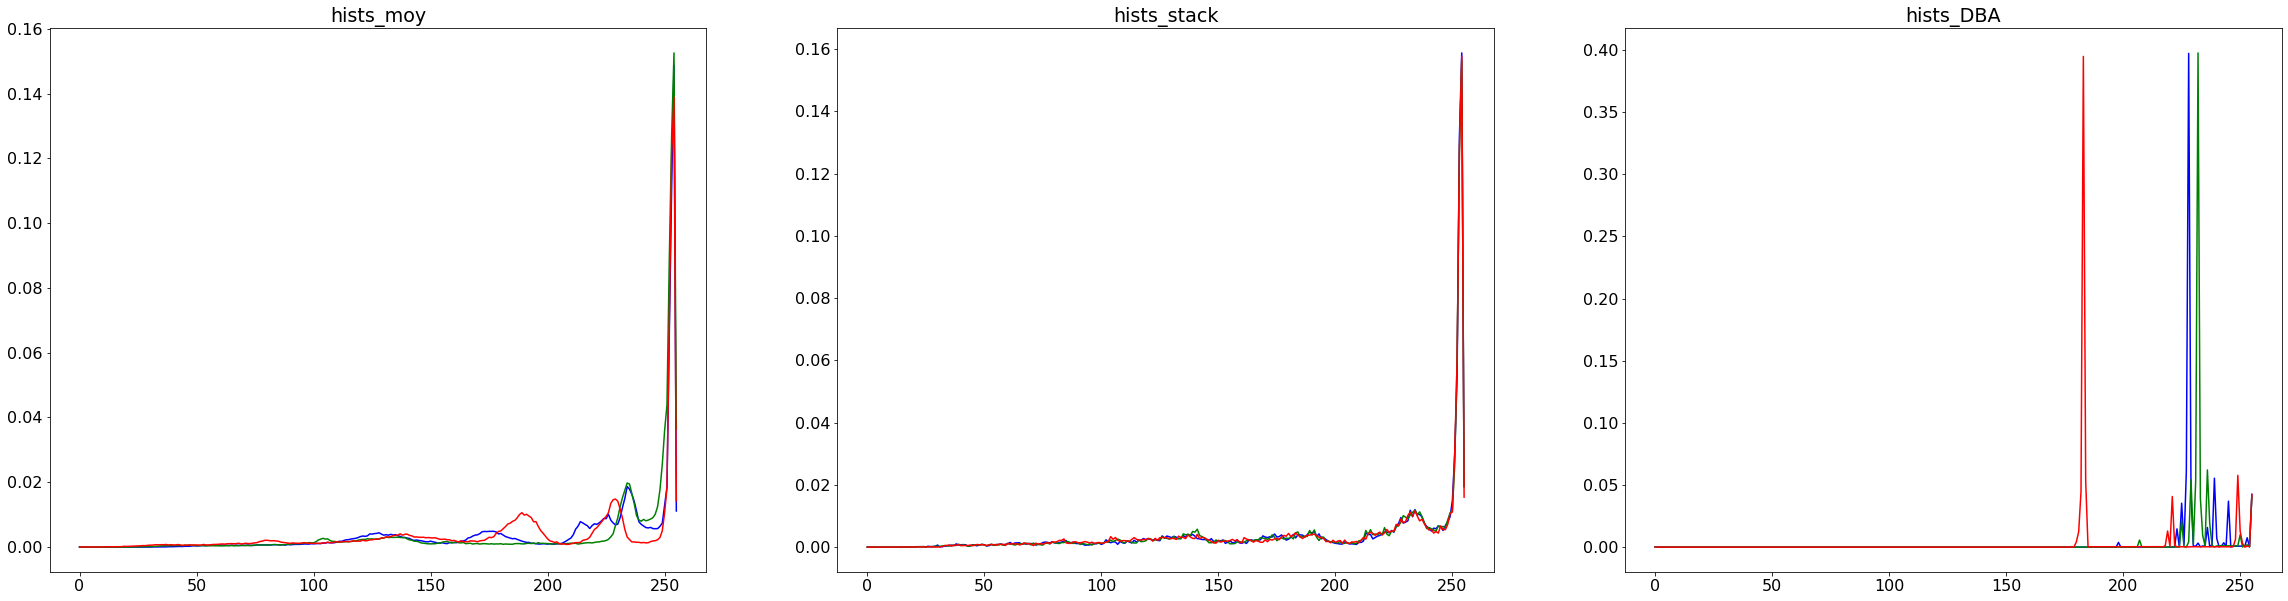

In [8]:
refs = [np.array(hists_moy, dtype='float32'), np.array(hists_stack, dtype='float32'), np.array(hists_DBA, dtype='float32')]
refsNames = ["hists_moy", "hists_stack", "hists_DBA"]
color = ('b','g','r')

plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(1, 3, figsize = (40, 10))
for i, histogram, name in zip(range(3), refs, refsNames):
    for j,col in enumerate(color):
        axs[i].plot(histogram[j],color = col)
        axs[i].set_title(name)
        # axs[i].set_legend(color)
plt.show()

## 3. Comparaison des similitudes

In [9]:
def getSimili(hist, histr, methode):
    """ calcul laa correlation entre deux histogrammes """
    # Normalisation des histogrammes
    temp = cv.normalize(histr, histr, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
    histr = temp/sum(temp)
    temp = cv.normalize(hist, hist, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
    hist = temp/sum(temp)
    # Utiliser cv2.HISTCMP_CORREL Méthodes de mesure
    return cv.compareHist(histr, hist, methode)

def getDistance(histr, hist):
    """ entrée : hist de réf, hist """
    return distance.euclidean(histr, hist)

#### Distance euclidienne

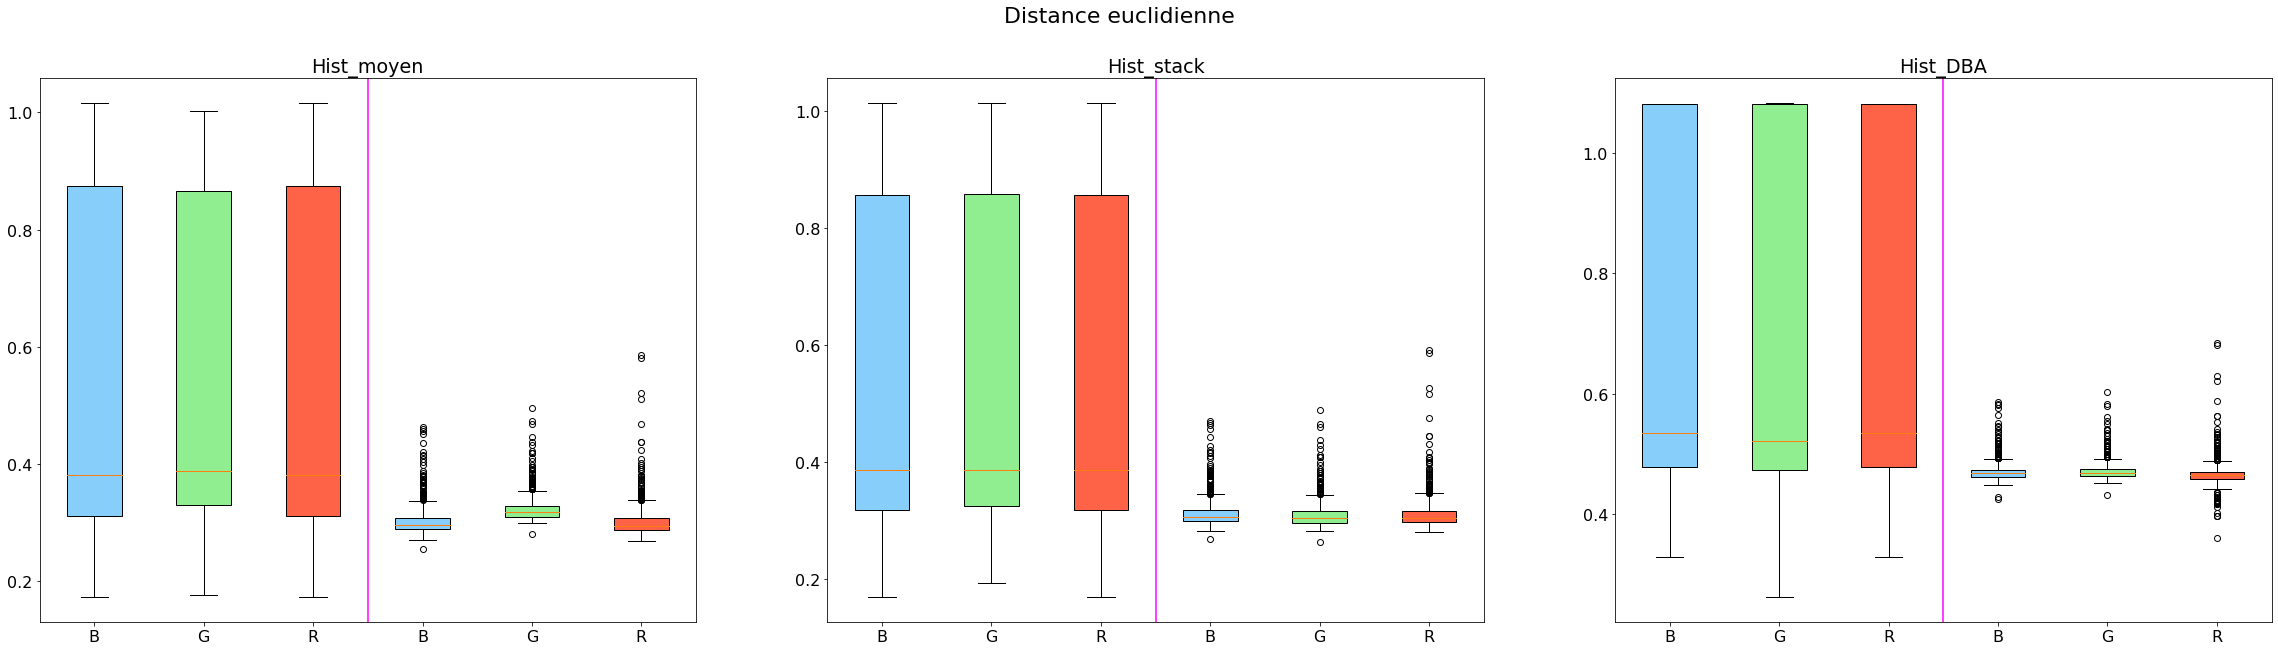

In [62]:
fig, axs = plt.subplots(1, 3, figsize = (40, 10))
labels = ['B', 'G', 'R', 'B', 'G', 'R']
plt.rcParams.update({'font.size': 16})
fig.suptitle('Distance euclidienne', fontsize=22)
axs[0].set_title('Hist_moyen')
axs[1].set_title('Hist_stack')
axs[2].set_title('Hist_DBA')
for i in range (3):
    AdistanceR, AdistanceG, AdistanceB = [], [], []
    for x in neige_test:
        AdistanceR.append(getDistance(normalize(cv.calcHist(x,[0],None,[256],[0,256])), refs[i][0]))
        AdistanceG.append(getDistance(normalize(cv.calcHist(x,[1],None,[256],[0,256])), refs[i][1]))
        AdistanceB.append(getDistance(normalize(cv.calcHist(x,[2],None,[256],[0,256])), refs[i][2]))
    # sans neige
    SdistanceR, SdistanceG, SdistanceB = [], [], []
    for x in sans_neige_test:
        SdistanceR.append(getDistance(normalize(cv.calcHist(x,[0],None,[256],[0,256])), refs[i][0]))
        SdistanceG.append(getDistance(normalize(cv.calcHist(x,[1],None,[256],[0,256])), refs[i][1]))
        SdistanceB.append(getDistance(normalize(cv.calcHist(x,[2],None,[256],[0,256])), refs[i][2]))

    bplots=[]
    bplots.append(axs[i].boxplot([AdistanceB, AdistanceG, AdistanceB, # avec neige
               SdistanceR, SdistanceG, SdistanceB], # sans neige
                labels=labels,
                patch_artist=True,  # fill with color
                ))
    axs[i].axvline(x=3.5, color='magenta')                   
    colors = ['lightskyblue', 'lightgreen', 'tomato', 'lightskyblue', 'lightgreen', 'tomato']

    for bplot in bplots:
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

plt.show()

#### Corrélation

  0%|          | 0/4 [00:00<?, ?it/s]

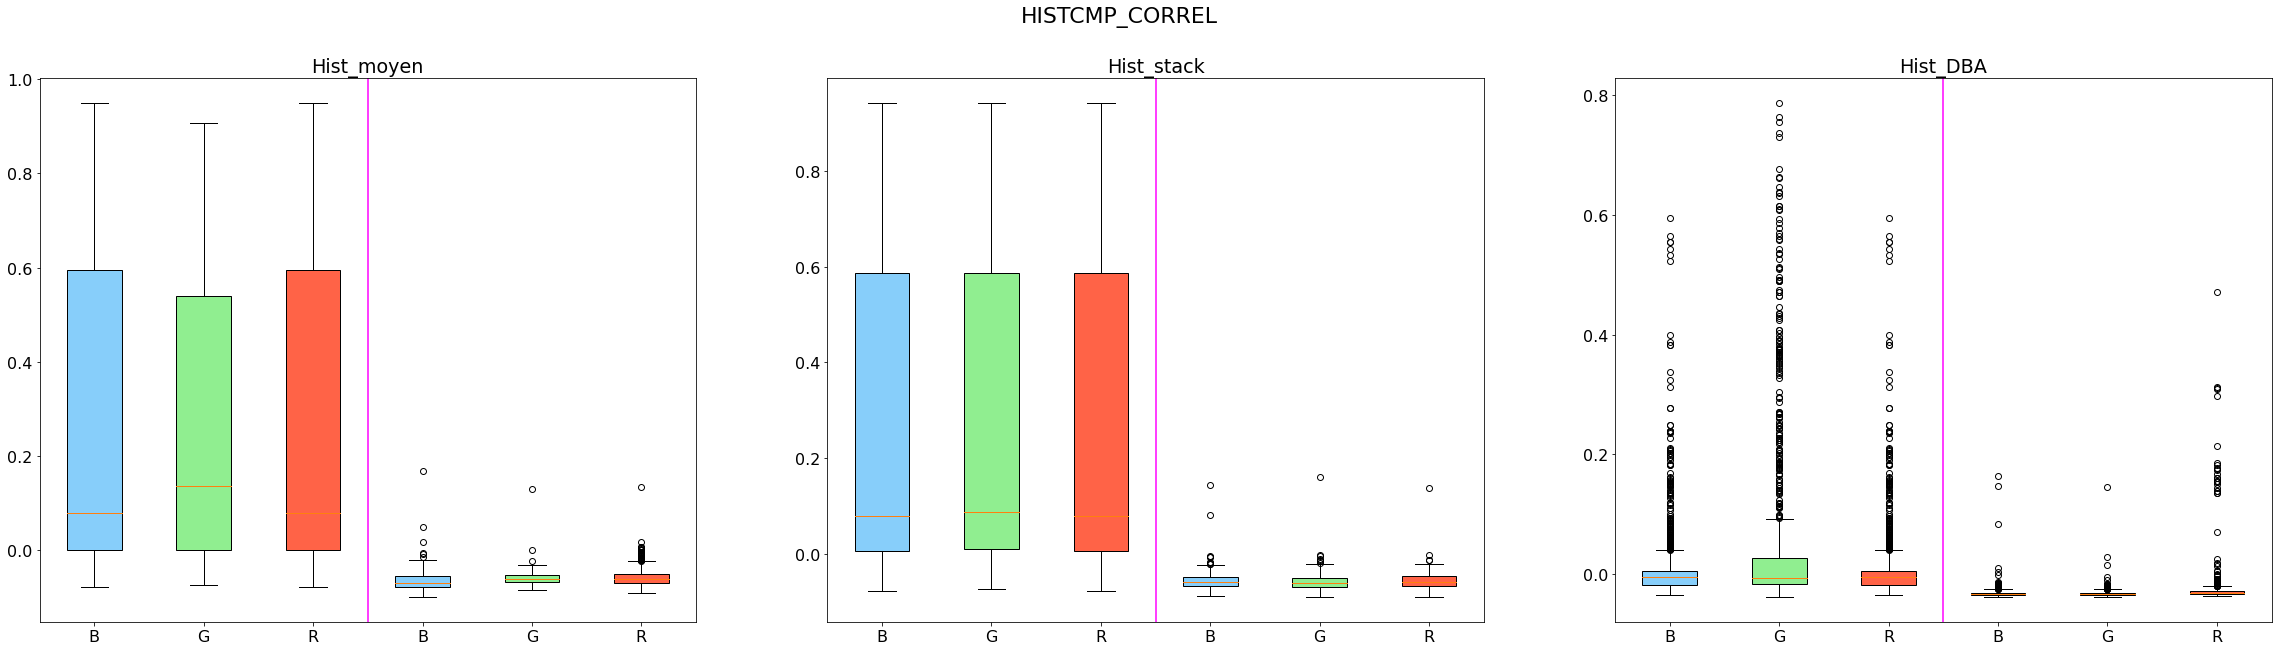

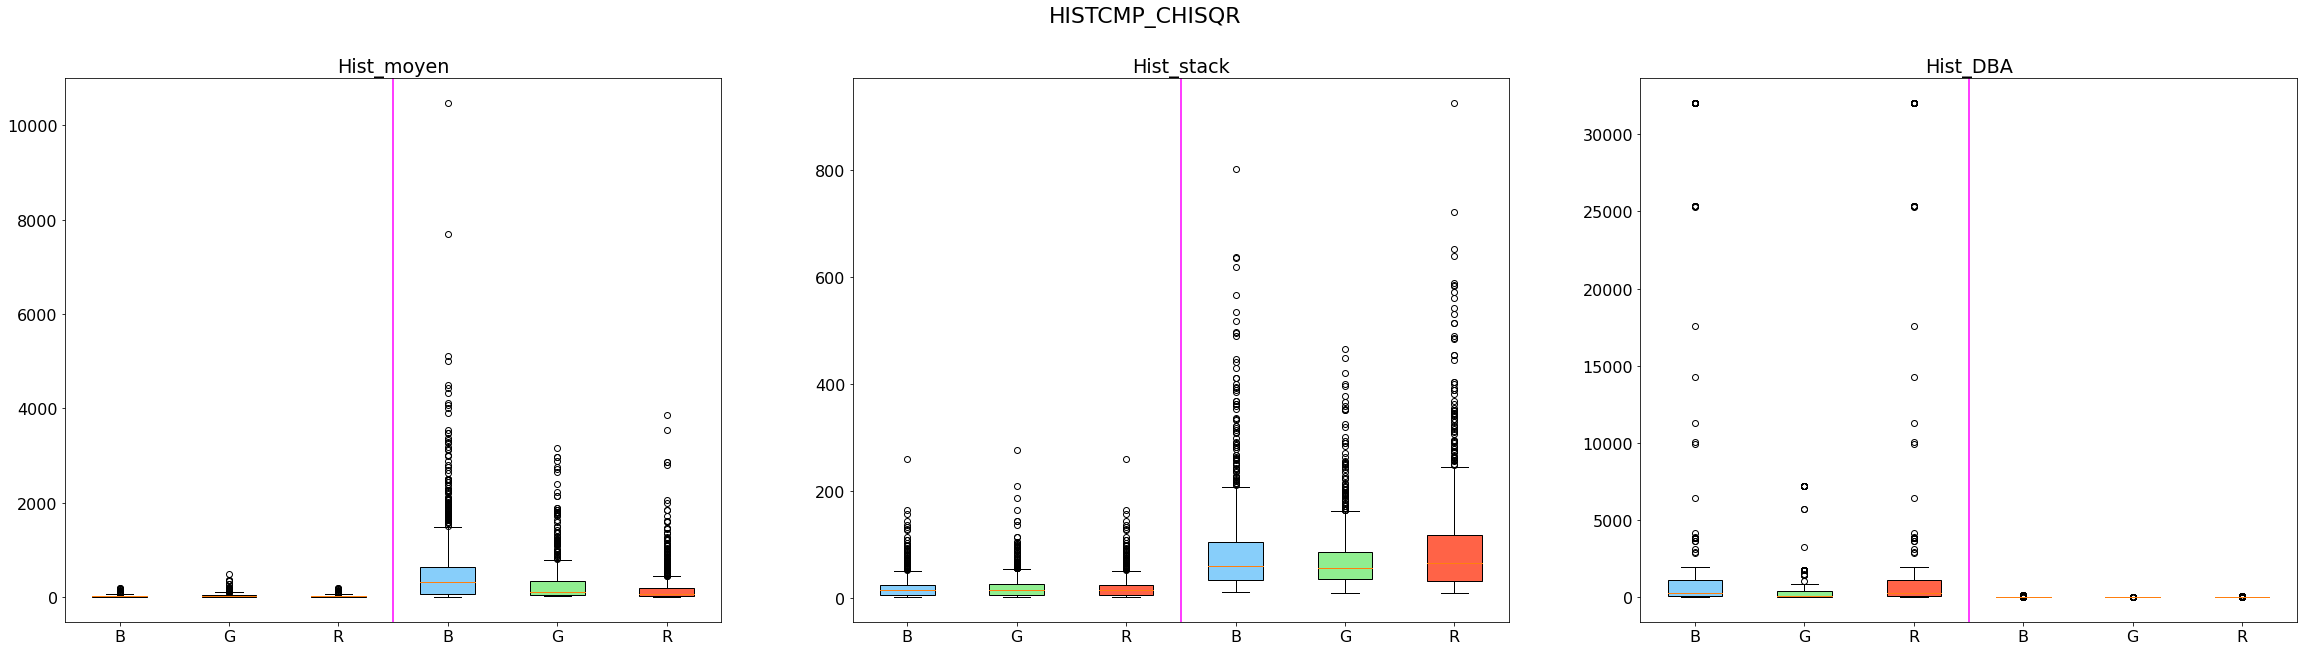

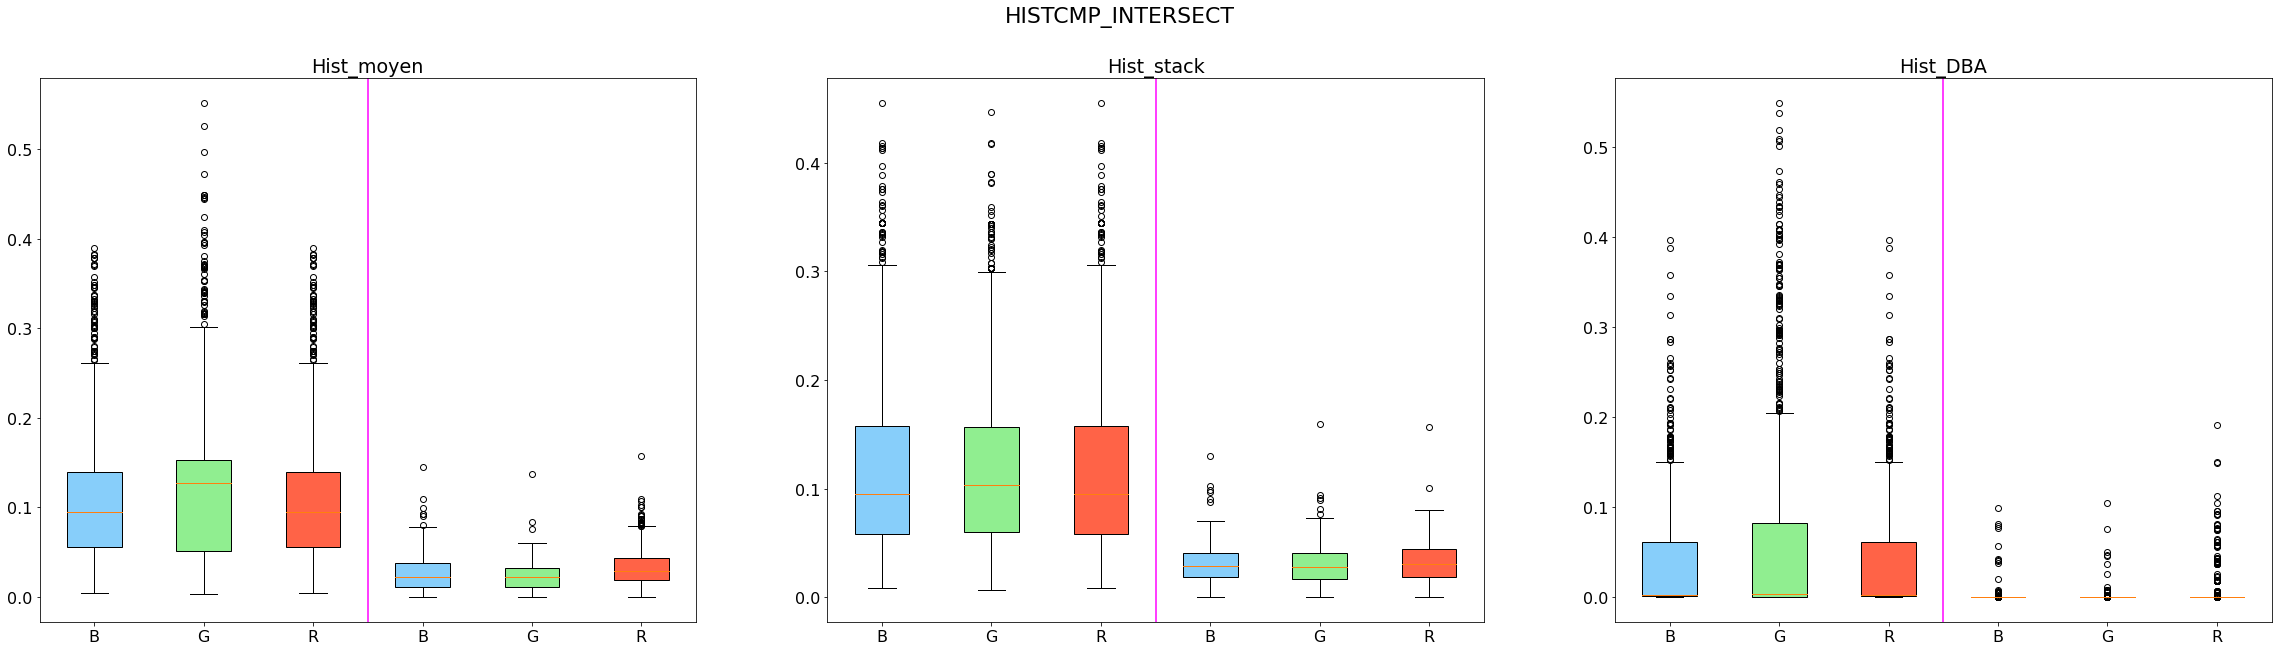

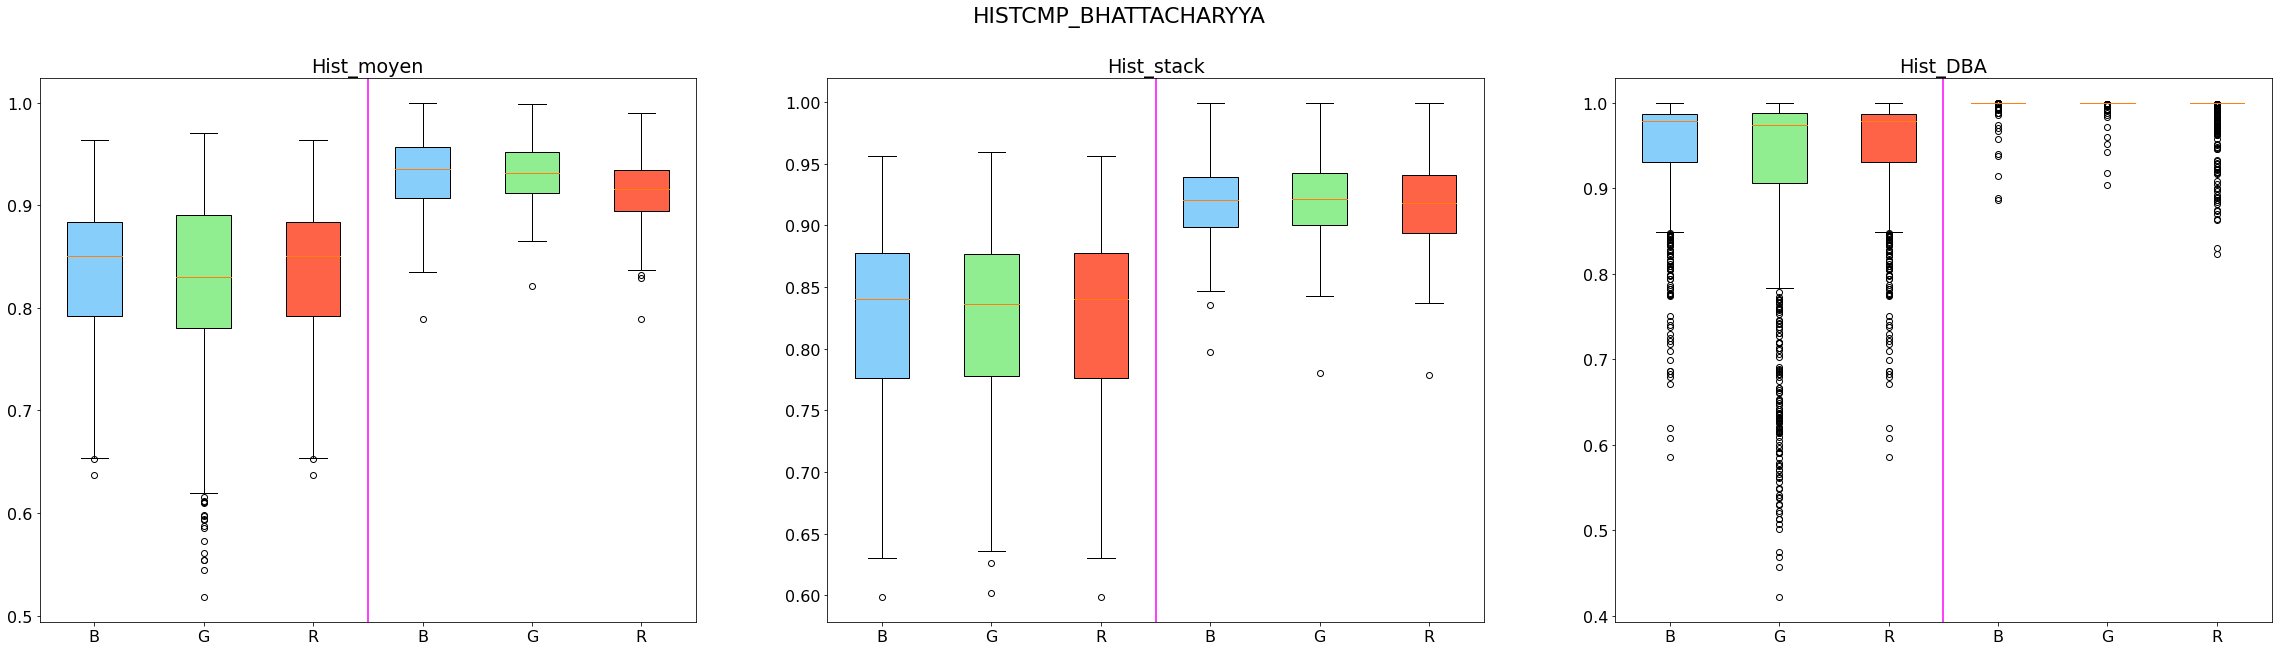

In [64]:
methodes = ["HISTCMP_CORREL", "HISTCMP_CHISQR", "HISTCMP_INTERSECT", "HISTCMP_BHATTACHARYYA"]
for k, meth in enumerate(tqdm(methodes)): 
    fig, axs = plt.subplots(1, 3, figsize = (40, 10))
    labels = ['B', 'G', 'R', 'B', 'G', 'R']
    plt.rcParams.update({'font.size': 16})
    fig.suptitle(meth, fontsize=22)
    axs[0].set_title('Hist_moyen')
    axs[1].set_title('Hist_stack')
    axs[2].set_title('Hist_DBA')
    for i in range (3):
        AdistanceR, AdistanceG, AdistanceB = [], [], []
        for x in neige_test:
            AdistanceR.append(getSimili(cv.calcHist(x,[0],None,[256],[0,256]), refs[i][0],k))
            AdistanceG.append(getSimili(cv.calcHist(x,[1],None,[256],[0,256]), refs[i][1],k))
            AdistanceB.append(getSimili(cv.calcHist(x,[2],None,[256],[0,256]), refs[i][2],k))
        # sans neige
        SdistanceR, SdistanceG, SdistanceB = [], [], []
        for x in sans_neige_test:
            SdistanceR.append(getSimili(cv.calcHist(x,[0],None,[256],[0,256]), refs[i][0],k))
            SdistanceG.append(getSimili(cv.calcHist(x,[1],None,[256],[0,256]), refs[i][1],k))
            SdistanceB.append(getSimili(cv.calcHist(x,[2],None,[256],[0,256]), refs[i][2],k))

        bplots=[]
        bplots.append(axs[i].boxplot([AdistanceB, AdistanceG, AdistanceB, # avec neige
                SdistanceR, SdistanceG, SdistanceB], # sans neige
                    labels=labels,
                    patch_artist=True,  # fill with color
                    ))
        axs[i].axvline(x=3.5, color='magenta')                   
        colors = ['lightskyblue', 'lightgreen', 'tomato', 'lightskyblue', 'lightgreen', 'tomato']

        for bplot in bplots:
            for patch, color in zip(bplot['boxes'], colors):
                patch.set_facecolor(color)

    plt.show()

Meilleur résultats pour la corrélation

#### Entropie croisée

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (40, 10))
labels = ['B', 'G', 'R', 'B', 'G', 'R']
plt.rcParams.update({'font.size': 16})
fig.suptitle('Entropie croisée', fontsize=22)
axs[0].set_title('Hist_moyen')
axs[1].set_title('Hist_stack')
axs[2].set_title('Hist_DBA')
for i in range (3):
    AdistanceR, AdistanceG, AdistanceB = [], [], []
    for x in neige_test:
        AdistanceR.append(kl_div(normalize(cv.calcHist(x,[0],None,[256],[0,256])), refs[i][0]))
        AdistanceG.append(kl_div(normalize(cv.calcHist(x,[1],None,[256],[0,256])), refs[i][1]))
        AdistanceB.append(kl_div(normalize(cv.calcHist(x,[2],None,[256],[0,256])), refs[i][2]))
    # sans neige
    SdistanceR, SdistanceG, SdistanceB = [], [], []
    for x in sans_neige_test:
        SdistanceR.append(kl_div(normalize(cv.calcHist(x,[0],None,[256],[0,256])), refs[i][0]))
        SdistanceG.append(kl_div(normalize(cv.calcHist(x,[1],None,[256],[0,256])), refs[i][1]))
        SdistanceB.append(kl_div(normalize(cv.calcHist(x,[2],None,[256],[0,256])), refs[i][2]))

    bplots=[]
    bplots.append(axs[i].boxplot([AdistanceB, AdistanceG, AdistanceB, # avec neige
               SdistanceR, SdistanceG, SdistanceB], # sans neige
                labels=labels,
                patch_artist=True,  # fill with color
                ))
    axs[i].axvline(x=3.5, color='magenta')                   
    colors = ['lightskyblue', 'lightgreen', 'tomato', 'lightskyblue', 'lightgreen', 'tomato']

    for bplot in bplots:
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

plt.show()

Pour la suite, il a été choisi d'utiliser l'histogramme stack comme référence et la carrélation comme méthode de comparaison

## 4. Evaluation des performances

Il faudrait mener une étude sur le choix optimal du seuil qui est différent pour chaque méthodes et référence

In [41]:
from sklearn.metrics import f1_score

# recherche du seuil qui maximise le f1 score
seuil = 0.9
f1score = 0
delta = 55
while delta>0 or delta>0.001:
    seuil = seuil-0.01
    predictions = []
    truth= []

    for patch in neige_train:
        if getDistance(normalize(cv.calcHist(patch,[0],None,[256],[0,256])), refs[i][0]) < seuil:
            predictions.append(0)
        else:
            predictions.append(1)
        truth.append(1)

    for patch in sans_neige_train:
        if getDistance(normalize(cv.calcHist(patch,[0],None,[256],[0,256])), refs[i][0]) < seuil:
            predictions.append(0)
        else:
            predictions.append(1)
        truth.append(0)
    delta = f1_score(truth, predictions)-f1score
    f1score = f1_score(truth, predictions)
    print(f1score)
print("seuil", seuil)

0.27209894507093485
0.27209894507093485
seuil 0.88


In [60]:
from sklearn.metrics import f1_score
def getScore(seuil):
    for patch in neige_train:
        if getDistance(normalize(cv.calcHist(patch,[0],None,[256],[0,256])), refs[i][0]) < seuil:
            predictions.append(0)
        else:
            predictions.append(1)
        truth.append(1)

    for patch in sans_neige_train:
        if getDistance(normalize(cv.calcHist(patch,[0],None,[256],[0,256])), refs[i][0]) < seuil:
            predictions.append(0)
        else:
            predictions.append(1)
        truth.append(0)
    return f1_score(truth, predictions)*-1

Opti